## Yields Prediction

#### Data extraction

In [56]:
import os
import rasterio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [50]:
yieldsData = pd.read_csv("Maize_yield_data_icipe_Mousa.csv")

Rwanda_Districts = gpd.read_file(r"D:\YieldsPrediction\Districts\District.shp").to_crs(epsg=4326)
# Calculate centroid coordinates for each district
Rwanda_Districts['Longitude'] = Rwanda_Districts.geometry.centroid.x
Rwanda_Districts['Latitude'] = Rwanda_Districts.geometry.centroid.y

# Display the DataFrame with new longitude and latitude columns
Rwanda_Districts[['District', 'Longitude', 'Latitude']]
# Join Rwanda_Districts and yieldsData along the "District" column
merged_data = Rwanda_Districts.merge(yieldsData, on="District", how="inner")


In [51]:

# Display the merged DataFrame
merged_data.columns

Index(['Dist_ID', 'District', 'geometry', 'Longitude', 'Latitude', '2023 B',
       '2023 A', '2022 A', '2022B', '2021 A', '2021 B', '2020 A', '2020 B',
       '2019 A', '2019 B', '2023 A.1', '2023 B.1', '2022 A.1', '2022 B',
       '2021 A.1', '2021 B.1', '2020 A.1', '2020 B.1', '2019 A.1', '2019 B.1'],
      dtype='object')

<Axes: >

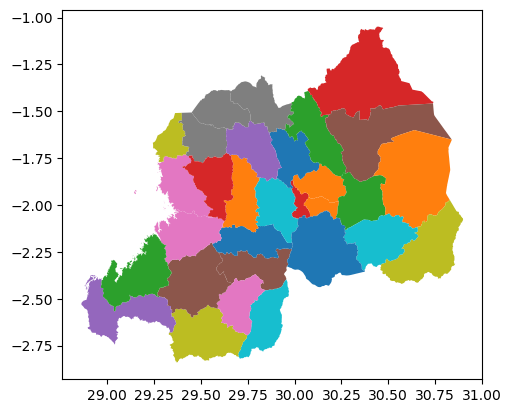

In [84]:
df = merged_data[["District","geometry","Longitude","Latitude","2020 B"]]
df.plot(column="2020 B")

In [85]:
# Define the folder containing your rasters
raster_folder = r"D:\YieldsPrediction\Variables"

# Load the CSV file containing longitude and latitude
points_df = df  

def extract_variables(points_df):
    # Iterate over each raster in the folder
    for raster_file in os.listdir(raster_folder):
        # Full path to the raster file
        raster_path = os.path.join(raster_folder, raster_file)
        
        # Skip if it's not a raster file (check for common extensions like .tif)
        if not raster_file.endswith(('.tif', '.tiff')):
            continue
        
        # Open the raster file
        with rasterio.open(raster_path) as src:
            # Create a list to store values for each point in the CSV
            values = []
            
            # Loop through each point in the CSV
            for _, row in points_df.iterrows():
                longitude = row['Longitude']
                latitude = row['Latitude']
                
                # Transform the latitude and longitude into the raster's coordinate system
                try:
                    raster_coords = src.index(longitude, latitude)
                    # Read the value at the specified location
                    value = src.read(1)[raster_coords[0], raster_coords[1]]
                except (IndexError, ValueError):
                    # If point is out of bounds for the raster, assign NaN
                    value = float('nan')
                    
                values.append(value)
            
            # Add the values as a new column to the DataFrame with the raster file's name as the column name
            column_name = os.path.splitext(raster_file)[0]  # remove file extension
            points_df[column_name] = values
            
    return points_df

points_df = extract_variables(points_df)
points_df.head()


,District,geometry,Longitude,Latitude,2020 B,AirTemperature,SurfaceSkinTemperature,SoilTemperature,Windspeed,Precipitation,Transpiration,LAI,EVI,Evapotranspiration,SoilMoisture,NDVI
0,Nyarugenge,"POLYGON ((29.98964 -1.86756, 29.98957 -1.86789...",30.028865,-1.992005,"1,239",19.096613,20.167261,20.161188,1.125386,0.076085,43.756985,2.094999,0.279652,0.701172,2951143.25,0.455804
1,Gasabo,"POLYGON ((30.14786 -1.79269, 30.14801 -1.79270...",30.142212,-1.891447,"1,112",19.096613,20.167261,20.161188,1.125386,0.076085,43.756985,1.941009,0.302540,0.701172,2951143.25,0.379459
2,Kicukiro,"POLYGON ((30.14356 -1.95412, 30.14402 -1.95429...",30.143725,-2.008864,"1,051",19.588098,20.181970,20.185876,0.959630,0.075615,51.451805,1.900589,0.281256,0.866056,3108321.25,0.358415
3,Nyanza,"POLYGON ((29.95084 -2.23321, 29.95146 -2.23339...",29.793463,-2.335861,"1,321",18.684869,19.835779,19.828363,1.276436,0.146463,51.642288,2.294635,0.474279,1.071734,2967753.50,0.546825
4,Gisagara,"POLYGON ((29.95559 -2.39686, 29.95584 -2.39749...",29.843603,-2.618112,999,18.488763,19.956445,19.959192,1.126331,0.050558,43.633720,2.677114,0.645519,1.040690,3280756.75,0.700990


### Generate Pseudo Data

### Visualize Data

In [62]:
df = points_df
df = df[['AirTemperature', 
       'Windspeed', 'Precipitation', 'Transpiration', 'LAI', 
       'Evapotranspiration','SoilMoisture','NDVI','2020 B']]
# Convert '2020 B' column to numeric, replacing ',' with ''
df['Yield'] = df['2020 B'].str.replace(',', '').astype(float)
df = df.drop(columns=['2020 B'])

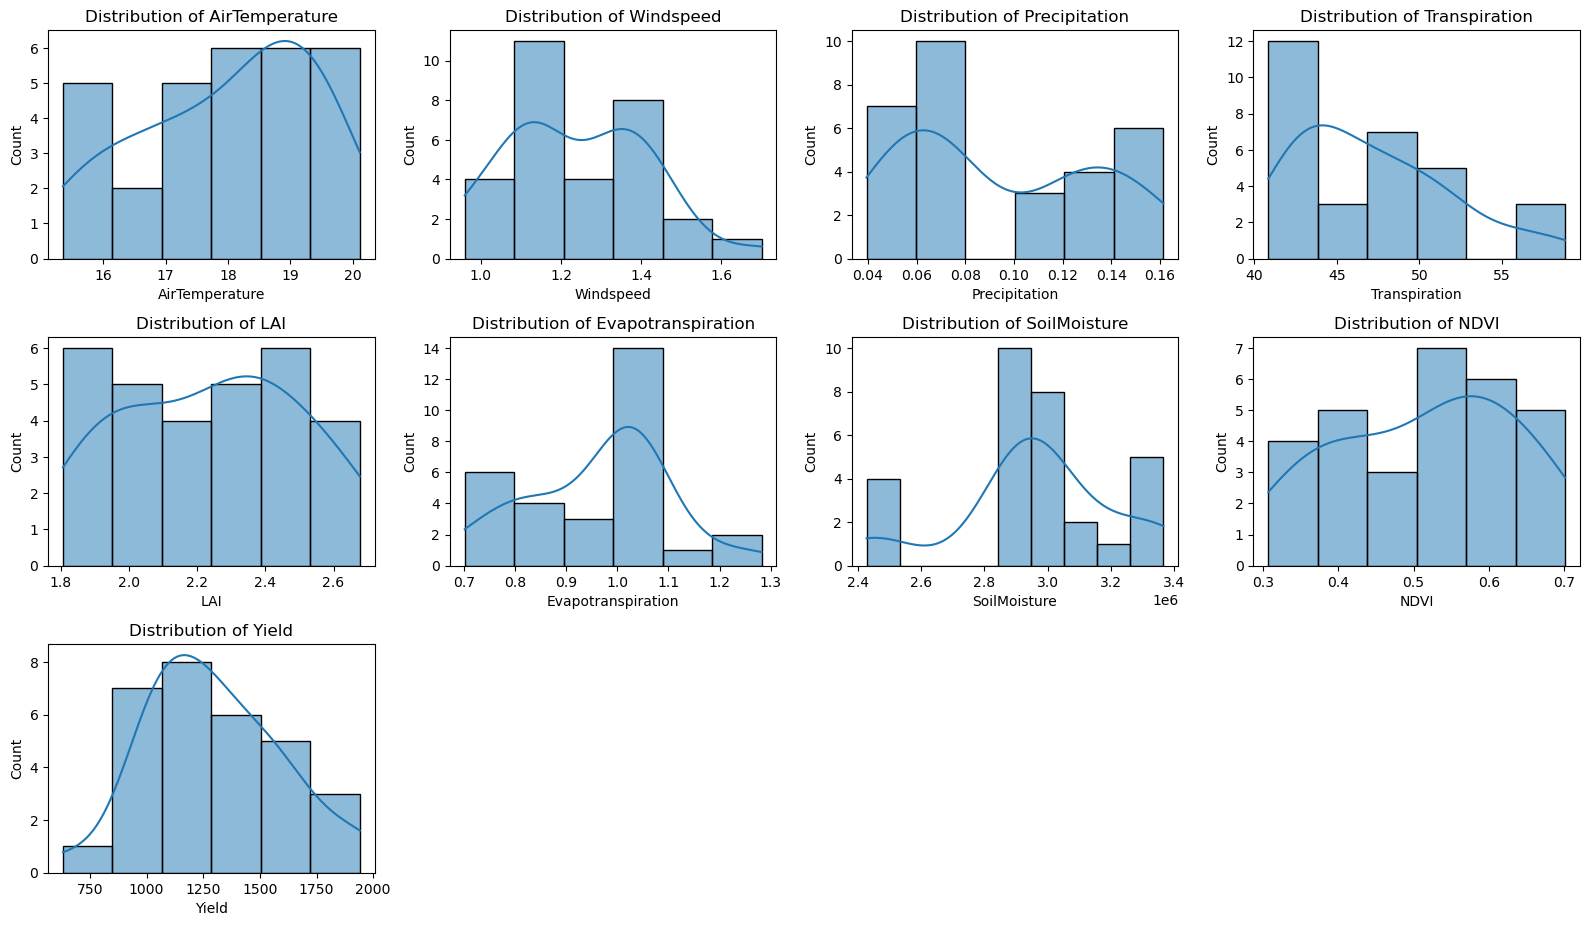

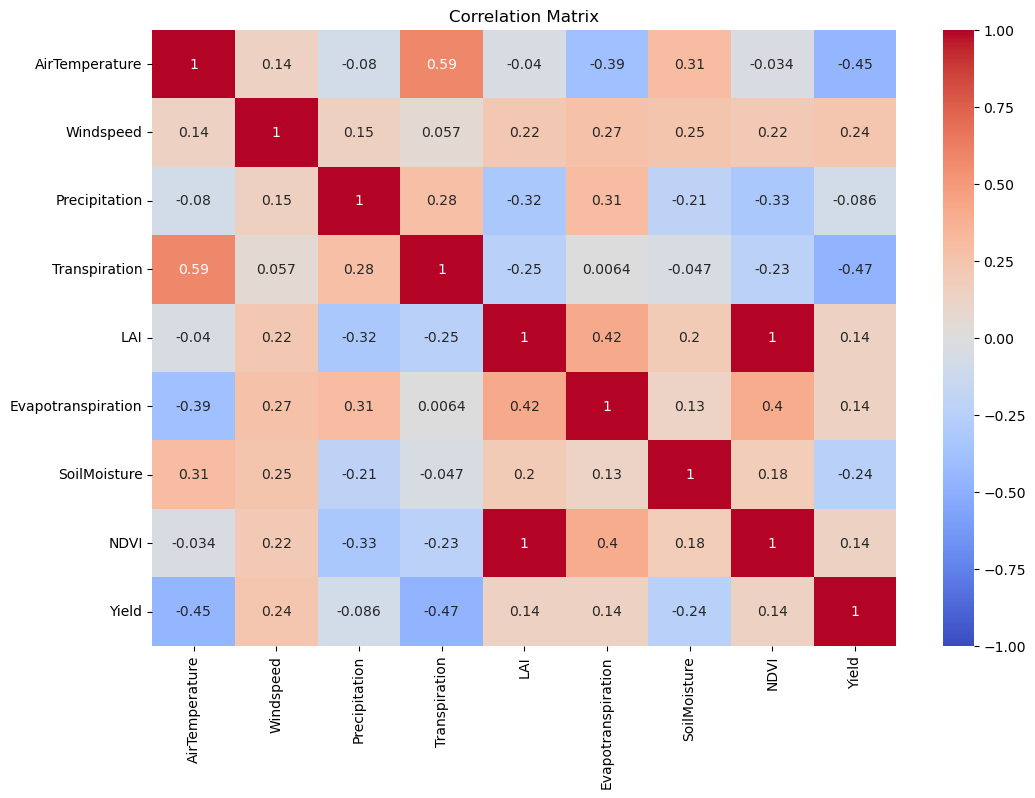

In [63]:

# Visualize the distribution of each feature
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))


# Now create the heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


### Data Cleaning (if necessary)

In [64]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check for outliers (Z-score method)
from scipy import stats
z_scores = np.abs(stats.zscore(df))
outliers = (z_scores > 3).sum(axis=0)
print("Outliers detected in each column:\n", outliers)

# Example: If we had missing values, we could fill them:
# df.fillna(df.mean(), inplace=True)


Missing values:
 AirTemperature        0
Windspeed             0
Precipitation         0
Transpiration         0
LAI                   0
Evapotranspiration    0
SoilMoisture          0
NDVI                  0
Yield                 0
dtype: int64
Outliers detected in each column:
 AirTemperature        0
Windspeed             0
Precipitation         0
Transpiration         0
LAI                   0
Evapotranspiration    0
SoilMoisture          0
NDVI                  0
Yield                 0
dtype: int64


### Train-Test Split

In [65]:
from sklearn.model_selection import train_test_split

# Features (X) and Target (y)
X = df.drop(columns=['Yield'])
y = df['Yield']

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shapes
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (21, 8)
Testing data shape: (9, 8)


In [67]:
X_train.head()

,AirTemperature,Windspeed,Precipitation,Transpiration,LAI,Evapotranspiration,SoilMoisture,NDVI
0,19.096613,1.125386,0.076085,43.756985,2.094999,0.701172,2951143.25,0.455804
4,18.488763,1.126331,0.050558,43.633720,2.677114,1.040690,3280756.75,0.700990
16,17.925287,0.975911,0.126913,50.616543,2.391307,1.039544,2988548.25,0.588091
5,17.237512,1.415722,0.046255,40.855652,2.668717,1.039441,3350719.50,0.697849
13,15.453882,1.107949,0.122559,42.836208,1.854366,0.949743,2475475.25,0.333793


### Feature Scaling

In [68]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train Models

In [70]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [71]:

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'SVR': SVR(),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}")


Training RandomForest...
RandomForest - RMSE: 304.5855, R2: -0.7131
Training XGBoost...
XGBoost - RMSE: 362.2496, R2: -1.4231
Training SVR...
SVR - RMSE: 243.7340, R2: -0.0970
Training ElasticNet...
ElasticNet - RMSE: 313.4106, R2: -0.8138
Training KNN...
KNN - RMSE: 261.0826, R2: -0.2587


### Evaluation and Prediction


Model Evaluation Results:
RandomForest: RMSE = 304.585, R2 = -0.713
XGBoost: RMSE = 362.250, R2 = -1.423
SVR: RMSE = 243.734, R2 = -0.097
ElasticNet: RMSE = 313.411, R2 = -0.814
KNN: RMSE = 261.083, R2 = -0.259
    Actual  Predicted
27  1729.0    1190.90
15  1277.0    1596.99
23  1137.0    1268.00
17  1125.0    1242.92
8   1023.0     995.82


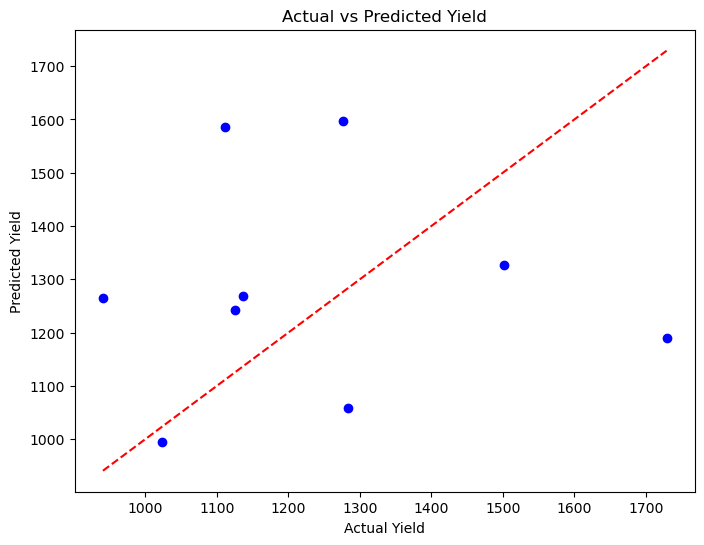

In [73]:
# Print results
print("\nModel Evaluation Results:")
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.3f}, R2 = {metrics['R2']:.3f}")

# Predict using the best model (example: XGBoost)
best_model = models['RandomForest']
y_pred = best_model.predict(X_test_scaled)

# Compare actual vs predicted values
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_results.head())

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")
plt.show()


### Prediction

#### Grid Rwanda

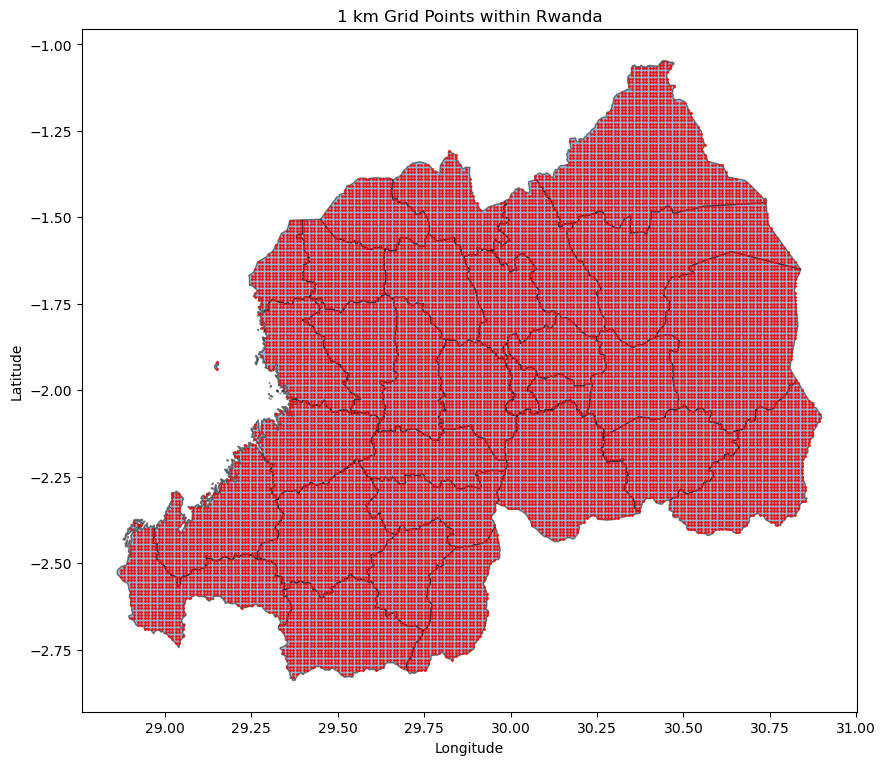

,geometry,index_right,Dist_ID,District,Longitude,Latitude
0,POINT (29.37173 -2.83023),5,23.0,Nyaruguru,29.371731,-2.83023
1,POINT (29.37173 -2.82023),5,23.0,Nyaruguru,29.371731,-2.82023
2,POINT (29.38173 -2.82023),5,23.0,Nyaruguru,29.381731,-2.82023
3,POINT (29.51173 -2.82023),5,23.0,Nyaruguru,29.511731,-2.82023
4,POINT (29.52173 -2.82023),5,23.0,Nyaruguru,29.521731,-2.82023


In [82]:
# Create a 1 km grid over Rwanda
xmin, ymin, xmax, ymax = Rwanda_Districts.total_bounds
x = np.arange(xmin, xmax, 0.01)  # 0.01 degrees is approximately 1 km
y = np.arange(ymin, ymax, 0.01)
xx, yy = np.meshgrid(x, y)
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xx.ravel(), yy.ravel()), crs=Rwanda_Districts.crs)

# Keep only points within Rwanda
points_within = gpd.sjoin(grid_points, Rwanda_Districts, how='inner', predicate='within')

# Add Longitude and Latitude columns
points_within['Longitude'] = points_within.geometry.x
points_within['Latitude'] = points_within.geometry.y

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
Rwanda_Districts.plot(ax=ax, alpha=0.5, edgecolor='k')
points_within.plot(ax=ax, color='red', markersize=1)
plt.title('1 km Grid Points within Rwanda')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Display the first few rows of the resulting DataFrame
points_within[['Longitude', 'Latitude']].head()
Rwanda_df = points_within
Rwanda_df = Rwanda_df.drop_duplicates().reset_index(drop=True)
Rwanda_df.head()

In [86]:
Rwanda_df = extract_variables(Rwanda_df)
Rwanda_df.head()


In [ ]:
Rwanda_df = Rwanda_df.dropna().drop_duplicates().reset_index(drop=True)
Rwanda_pred = Rwanda_df[X_train.columns]
Rwanda_df["PreictedYields"] = best_model.predict(Rwanda_pred)
